# Final Project
C&EE 211, Winter 2025
Alireza Shayegani, UID:
Budhaditya De, UID: 206182210

## Introduction

In this project, a machine learning task is to be carried out in predicting the health state diagnostics of the crusher in a Copper mining plant. Based on the raw sensor data with timestamps provided for the instants at which recordings were taken along with values for different features, the first step after preprocessing the data is to determine which timestamps were associated with the failure of the crusher. A separate spreadsheet with the plant downtime descriptions, periods and there possible causes were also provided. As shall be discussed in detail in the upcoming sections, this spreadsheet was used to identify the timestamps which fell within the downtime intrvals corresponding to the crusher failure. Accordingly, all data rows where this condition held true, were tagged with 1 and the rest as 0 (since we are only interested with the crusher health state dagnostics for this study). Later on, with the prepared dataframe (features and labels), a variety of machine learning models were fit and the accuracy of the health state predictions were compared amongst all the models. 

1.) The first and foremost step in this study was to prepare the raw dataset through preprocessing. 
a) After naming the feature columns, and dropping the 'unnameed' column, only the features relevant for this study was chosen (i.e. the first 13 columns from 'Current[I]' to 'Setting[S]'). 
b) Then the different types of non-numeric entries in the dataframe were identified. The following types of entries were found out apart from NaNs: 'I/O Timeout', ' ', 'Intf Shut', 'Shutdown', 'Bad Input'. These non-numeric entries were converted to NaNs. 
c) Interestingly, it was observed that all rows where the 'Timestamp' column had 'NaNs', all corresponding feature columns were all 'NaNs' as well. Therefore, when all rows where all features were 'NaNs' got deleted, the 'Timestamp' column was automatically cleaned from its 'NaN' entries. 
d) The sensor data file had the timestamp recordings from July 1st/2017 to October 1st/2019 while the data logs file containing the time intervals for the plant downtime had entries from January 2nd/2017 to August 31st/2019. For purposes of this study, we only needed data falling within the overlap of both these time recordings and accordingly, the sensor dataframe was filtered to have the timestamps falling within July 1st/2017 to August 31st/2019.
e) All feature column datatypes were converted to 'float64'.
f) The dataframe was further filtered such that the rows containing one or more negative entries of the feature data were dropped.
g) Next, the 'Timestamp' column was converted to 'DateTime' datatype. 
h) All feature columns which had more than 33% NaNs were dropped.
i) Forward filling was done on the feature dataframe.
j) Feature reduction through Coeffcient of Variability (CV) and Correlation coefficient (Pearson's) was carried out. All features where the CV was less than 0.05 were dropped. Also, if the correlation coefficent of a feature pair was more than 95%, one of the features of that pair was dropped.

In [1]:
%load_ext autoreload
%autoreload 2
%reset -f
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
# Reading raw sensor dataset
df_sensor = pd.read_csv('Copper_Mining_Raw_Sensor_Data.csv', header = 'infer')

import project
df_sensor_filtered = project.preprocessing(df_sensor)

2.) In the 2nd step, the identification of the plant downtime due to crusher failure was carried out. For this, the downtime spreadsheet was first filtered to obtain the cases of operational downtime only due the failures of any of the equipment. Then, further filtering was done to extract the time intervals for plant downtime due to only the 'crusher' failure. The time intervals entries were converted to 'DateTime' datatype and For efficient searching of the health state tag for each sensor data timestamp, the crsuher failure time intervals were sorted by their 'start' instant. 

In [2]:
df_downs = project.downtime_filtering()

3.) Now for identifying the health state labels related to only the crusher failure from synchorization between the sensor data and the down time logs, the following steps were carried out.
a) A single column vector of zeros was initialized in the beginning with the size same as the feature dataframe rows.
b) The first instance where the start time of the relevant intervla which might enclose the concerned sensor timestamp was identified and then iteratively the end time of the interval was checked to make sure if the concerned sensor timestamp existed wiithin that interval. 
c) All row indices of the feature dataframe which held true to this condition were saved and the zeros corresponding to these rows, were replaced with 1s to indicate that the crusher had failed during that recorded sensor data timestamp.

A total of 1444 1s were observed.

In [3]:
df_sensor_filtered_labeled = project.health_state_labeling(df_downs,df_sensor_filtered)

4.) For doing the PCA, the entire dataframe including the features and health state labels for the copper mining crusher was splitted in 80/20 ratio into train and test datasets. Next Standard scaling was performed on the training set and then used for transforming the test dataset. The PCA was then done on the feature training set and using it the test feature set was transformed. The PCA resulted in 10 components which cumulated to 95% of explained variance. 

Explained Variance Ratio: [0.2309083  0.1742897  0.13216919 0.11684015 0.09100382 0.0729376
 0.05589742 0.04701323 0.02830547 0.02296044]
Total Explained Variance: 97.23%


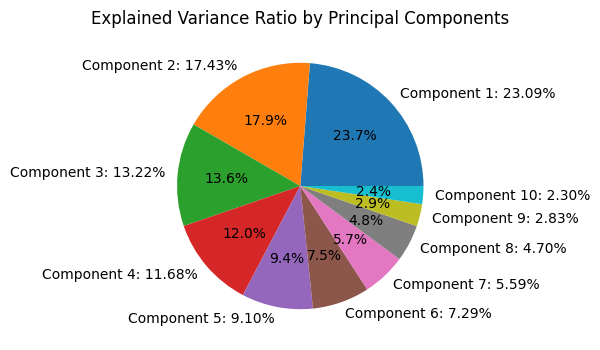

In [6]:
x_train_pca, x_test_pca, y_train, y_test = project.PCA_transform(df_sensor_filtered_labeled)

5.) Various machine learing regressors were sequentially trained and tested on the dataframe for predicting the health state of the crusher. These models were trained using both PCA decomposed dataset as well as the dataset with all 13 features. Results for each model's prediction capabilities are presented meticulously in the following subsections.

a) Logistic Regression: The Logistic regressor was fitted to the all-feature dataset and the PCA dataset with the following parameters, penalty = 'l2', C = 100, random_state = 42, max_iter = 1000. The choice of these parameters were finalized after some manual trials and tuning. As can be seen from the results, the PCA-transformed dataset performs slightly better in the predictions on the train and test splits. 

Accuracy on train dataset: 85.51%
              precision    recall  f1-score   support

     Healthy    0.99923   0.85573   0.92193     78858
     Failure    0.01982   0.81560   0.03869       282

    accuracy                        0.85559     79140
   macro avg    0.50952   0.83567   0.48031     79140
weighted avg    0.99574   0.85559   0.91878     79140

Balanced Accurancy: 0.83567
Unbalanced Accurancy: 0.85559

 Accuracy on train PCA dataset: 86.12%
              precision    recall  f1-score   support

     Healthy    0.99925   0.86211   0.92563     78858
     Failure    0.02080   0.81915   0.04057       282

    accuracy                        0.86195     79140
   macro avg    0.51003   0.84063   0.48310     79140
weighted avg    0.99576   0.86195   0.92247     79140

Balanced PCA Accurancy: 0.84063
Unbalanced PCA Accurancy: 0.86195


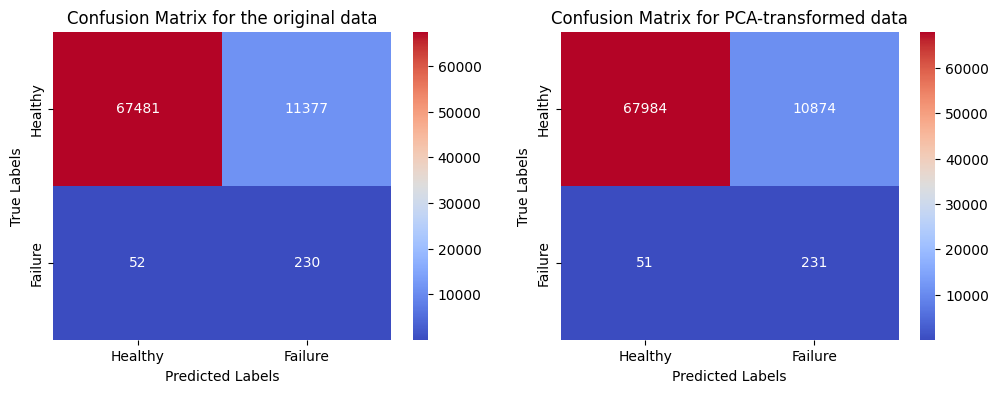

In [9]:
from sklearn.linear_model import LogisticRegression
labels_names = ['Healthy', 'Failure']
features = np.asarray(df_sensor_filtered_labeled.iloc[:, :-1])
labels = np.asarray(df_sensor_filtered_labeled.iloc[:, -1:])
modeler = LogisticRegression(penalty = 'l2', C = 100, random_state = 42, max_iter = 1000, class_weight='balanced')
cm = project.ML_modeler(features,labels,labels_names,modeler)
cm_PCA = project.ML_modeler_for_PCA(x_train_pca, x_test_pca, y_train, y_test, labels_names, modeler)
project.CM_plotter(cm, cm_PCA, labels_names)

Fig.1: Confusion matrices for all-feature (a) and PCA-transformed (b) dataframe for health state prediction of the copper mining crusher using Logistic Regression. 

b) Nonlinear support vector regressor (NLSVR): The NLSVR was fitted to the all-feature dataset and the PCA dataset with the following parameters, kernel = 'rbf', C = 10, gamma = 'auto', class_weight='balanced' The choice of these parameters were finalized after some manual trials and tuning. For this moddel, the results are better than the logistic regression, but the PCA-transformed dataset performed slightly poor compared to the all-feature dataset.

Accuracy on train dataset: 97.93%
              precision    recall  f1-score   support

     Healthy    0.99946   0.97815   0.98869     78858
     Failure    0.12226   0.85106   0.21381       282

    accuracy                        0.97770     79140
   macro avg    0.56086   0.91461   0.60125     79140
weighted avg    0.99633   0.97770   0.98593     79140

Balanced Accurancy: 0.91461
Unbalanced Accurancy: 0.97770

 Accuracy on train PCA dataset: 97.80%
              precision    recall  f1-score   support

     Healthy    0.99942   0.97692   0.98804     78858
     Failure    0.11522   0.84043   0.20265       282

    accuracy                        0.97643     79140
   macro avg    0.55732   0.90867   0.59535     79140
weighted avg    0.99627   0.97643   0.98524     79140

Balanced PCA Accurancy: 0.90867
Unbalanced PCA Accurancy: 0.97643


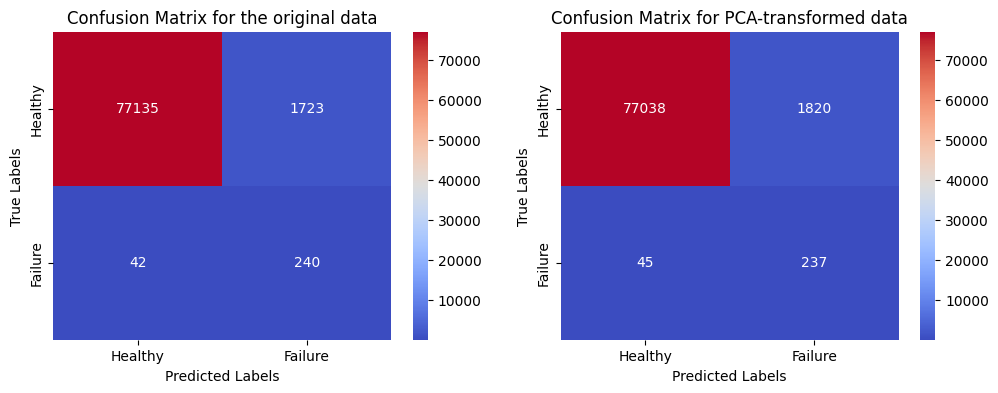

In [11]:
from sklearn.svm import SVC
modeler = SVC(kernel = 'rbf', C = 10, gamma = 'auto', class_weight='balanced')
cm=project.ML_modeler(features,labels,labels_names,modeler)
cm_PCA=project.ML_modeler_for_PCA(x_train_pca, x_test_pca, y_train, y_test, labels_names, modeler)
project.CM_plotter(cm, cm_PCA, labels_names)

Fig.2: Confusion matrices for all-feature (a) and PCA-transformed (b) dataframe for health state prediction of the copper mining crusher using Nonlinear SVC

Accuracy on train dataset: 98.77%
              precision    recall  f1-score   support

     Healthy    0.99892   0.98580   0.99232     78858
     Failure    0.15023   0.70213   0.24750       282

    accuracy                        0.98479     79140
   macro avg    0.57457   0.84396   0.61991     79140
weighted avg    0.99590   0.98479   0.98966     79140

Balanced Accurancy: 0.84396
Unbalanced Accurancy: 0.98479

 Accuracy on train PCA dataset: 98.40%
              precision    recall  f1-score   support

     Healthy    0.99875   0.98255   0.99058     78858
     Failure    0.11851   0.65603   0.20076       282

    accuracy                        0.98139     79140
   macro avg    0.55863   0.81929   0.59567     79140
weighted avg    0.99561   0.98139   0.98777     79140

Balanced PCA Accurancy: 0.81929
Unbalanced PCA Accurancy: 0.98139


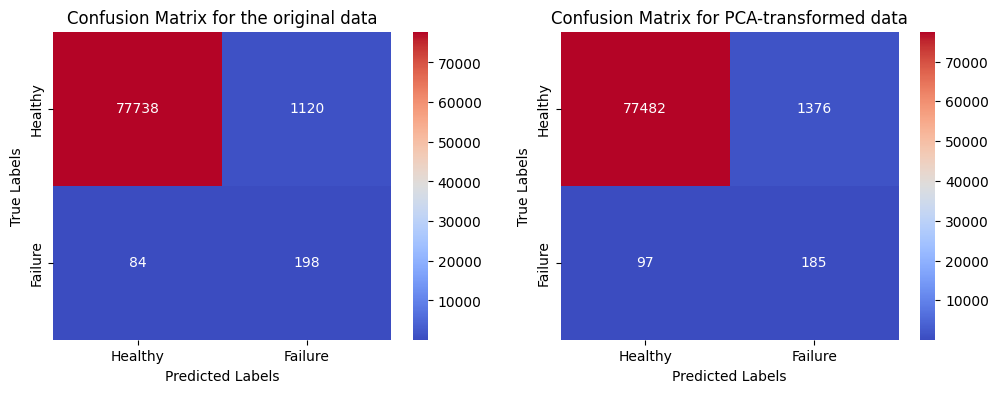

In [12]:
from sklearn.tree import DecisionTreeClassifier
modeler = DecisionTreeClassifier(criterion = 'gini', max_depth = 20, min_samples_split = 20, min_samples_leaf = 5, min_impurity_decrease = 0, random_state = 42, class_weight='balanced')
cm=project.ML_modeler(features,labels,labels_names,modeler)
cm_PCA=project.ML_modeler_for_PCA(x_train_pca, x_test_pca, y_train, y_test, labels_names, modeler)
project.CM_plotter(cm, cm_PCA, labels_names)

Fig.3: Confusion matrices for all-feature (a) and PCA-transformed (b) dataframe for health state prediction of the copper mining crusher using Decision tree classifier

Accuracy on train dataset: 99.73%
              precision    recall  f1-score   support

     Healthy    0.99853   0.99729   0.99791     78858
     Failure    0.43684   0.58865   0.50151       282

    accuracy                        0.99583     79140
   macro avg    0.71768   0.79297   0.74971     79140
weighted avg    0.99653   0.99583   0.99614     79140

Balanced Accurancy: 0.79297
Unbalanced Accurancy: 0.99583

 Accuracy on train PCA dataset: 99.57%
              precision    recall  f1-score   support

     Healthy    0.99824   0.99532   0.99678     78858
     Failure    0.28070   0.51064   0.36226       282

    accuracy                        0.99359     79140
   macro avg    0.63947   0.75298   0.67952     79140
weighted avg    0.99569   0.99359   0.99452     79140

Balanced PCA Accurancy: 0.75298
Unbalanced PCA Accurancy: 0.99359


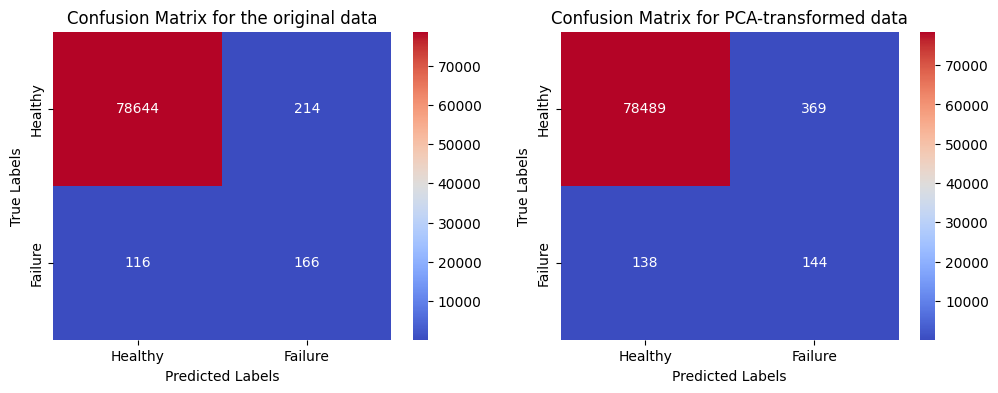

In [ ]:
from sklearn.ensemble import RandomForestClassifier
modeler = RandomForestClassifier(criterion = 'gini',  max_depth = 20,  min_samples_split = 20, min_samples_leaf = 5, 
                                 min_impurity_decrease = 0, random_state = 42, n_estimators = 100, bootstrap = True, 
                                 oob_score = False, n_jobs=-1, class_weight='balanced')
cm=project.ML_modeler(features,labels,labels_names,modeler)
cm_PCA=project.ML_modeler_for_PCA(x_train_pca, x_test_pca, y_train, y_test, labels_names, modeler)
project.CM_plotter(cm, cm_PCA, labels_names)

Fig.4: Confusion matrices for all-feature (a) and PCA-transformed (b) dataframe for health state prediction of the copper mining crusher using Random Forest classifier

Accuracy on train dataset: 99.81%
              precision    recall  f1-score   support

     Healthy    0.99796   0.99762   0.99779     78858
     Failure    0.39159   0.42908   0.40948       282

    accuracy                        0.99559     79140
   macro avg    0.69477   0.71335   0.70363     79140
weighted avg    0.99580   0.99559   0.99569     79140

Balanced Accurancy: 0.71335
Unbalanced Accurancy: 0.99559

 Accuracy on train PCA dataset: 99.73%
              precision    recall  f1-score   support

     Healthy    0.99731   0.99718   0.99725     78858
     Failure    0.23973   0.24823   0.24390       282

    accuracy                        0.99452     79140
   macro avg    0.61852   0.62271   0.62058     79140
weighted avg    0.99461   0.99452   0.99456     79140

Balanced PCA Accurancy: 0.62271
Unbalanced PCA Accurancy: 0.99452


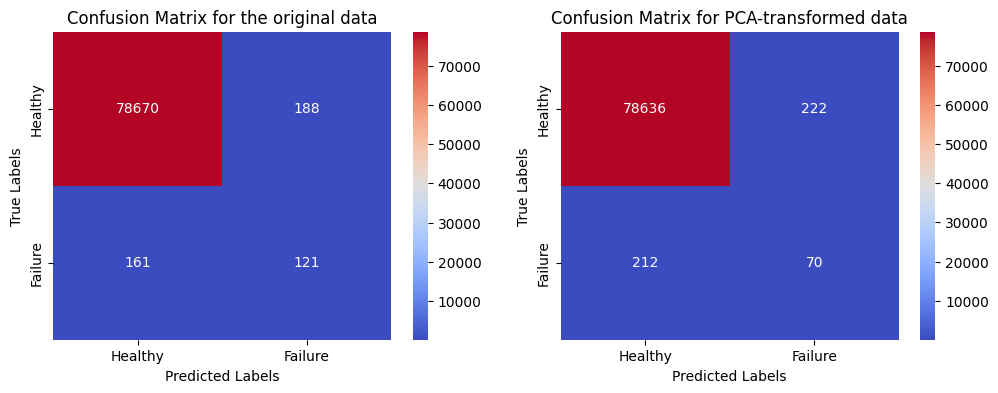

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
# Compute class weights manually (inverse frequency)
labels_falttened = np.ravel(labels)
classes = np.unique(labels_falttened)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=labels_falttened)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
# Assign sample weights based on class labels
sample_weights = np.array([class_weight_dict[label] for label in labels_falttened])
# Define the GradientBoostingClassifier model
modeler = GradientBoostingClassifier(max_depth=10, n_estimators=100, learning_rate=0.5, random_state=42)
# Train the model with sample weights
cm = project.ML_modeler(features, labels, labels_names, modeler.fit(features, labels, sample_weight=sample_weights))

#-----------------------------------------The code below is for PCA -----------------------------------------#
# Compute class weights based on y_train
y_train_falttened = np.ravel(y_train)
classes = np.unique(y_train_falttened)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_falttened)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
# Assign sample weights to each training instance
sample_weights_PCA = np.array([class_weight_dict[label] for label in y_train_falttened])
# Define the GradientBoostingClassifier model
modeler_PCA = GradientBoostingClassifier(max_depth=10, n_estimators=100, learning_rate=0.5, random_state=42)
# Train the model using only the training data (PCA-transformed) with sample weights
modeler_PCA.fit(x_train_pca, y_train_falttened, sample_weight=sample_weights_PCA)
# Call the function with the pre-trained model
cm_PCA = project.ML_modeler_for_PCA(x_train_pca, x_test_pca, y_train_falttened, y_test, labels_names, modeler_PCA)
project.CM_plotter(cm, cm_PCA, labels_names)


Fig.5: Confusion matrices for all-feature (a) and PCA-transformed (b) dataframe for health state prediction of the copper mining crusher using Gradient Boosting classifier

Accuracy on train dataset: 98.12%
              precision    recall  f1-score   support

     Healthy    0.99955   0.98122   0.99030     78858
     Failure    0.14294   0.87589   0.24577       282

    accuracy                        0.98084     79140
   macro avg    0.57124   0.92855   0.61803     79140
weighted avg    0.99650   0.98084   0.98765     79140

Balanced Accurancy: 0.92855
Unbalanced Accurancy: 0.98084

 Accuracy on train PCA dataset: 95.89%
              precision    recall  f1-score   support

     Healthy    0.99937   0.95861   0.97856     78858
     Failure    0.06690   0.82979   0.12381       282

    accuracy                        0.95815     79140
   macro avg    0.53313   0.89420   0.55119     79140
weighted avg    0.99604   0.95815   0.97552     79140

Balanced PCA Accurancy: 0.89420
Unbalanced PCA Accurancy: 0.95815


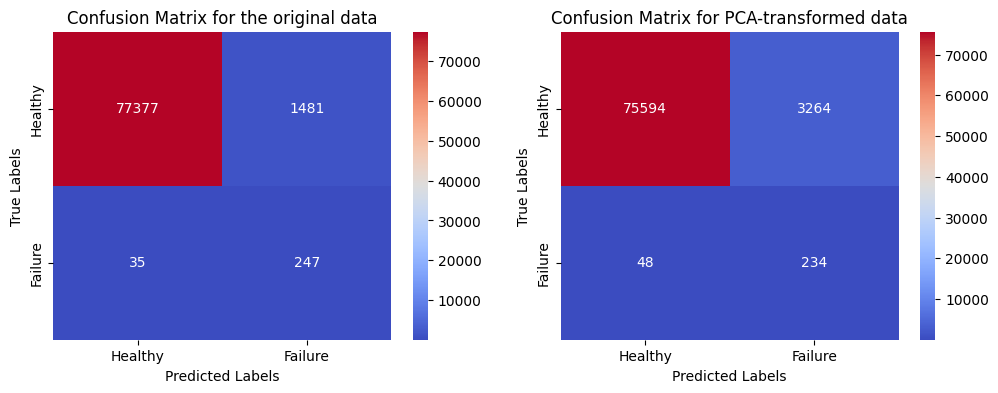

In [20]:
from sklearn.ensemble import HistGradientBoostingClassifier
modeler = HistGradientBoostingClassifier(learning_rate=0.5, loss ='log_loss', max_depth=10, max_features=0.2, max_iter=100, class_weight='balanced')
cm=project.ML_modeler(features,labels,labels_names,modeler)
cm_PCA=project.ML_modeler_for_PCA(x_train_pca, x_test_pca, y_train, y_test, labels_names, modeler)
project.CM_plotter(cm, cm_PCA, labels_names)

Fig.6: Confusion matrices for all-feature (a) and PCA-transformed (b) dataframe for health state prediction of the copper mining crusher using Histograam Gradient Boosting classifier

Is the data balanced?
Training data samples per class: [315396   1162]
Test data samples per class: [78858   282]
Weight for class 0: 1.003684
Weight for class 1: 272.425129


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,611 (143.01 KB)

 Trainable params: 36,611 (143.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6856 - loss: 1.1700 - val_accuracy: 0.7844 - val_loss: 0.4936
Epoch 2/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8337 - loss: 0.8120 - val_accuracy: 0.9337 - val_loss: 0.1943
Epoch 3/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8604 - loss: 0.7408 - val_accuracy: 0.8185 - val_loss: 0.4646
Epoch 4/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8706 - loss: 0.6857 - val_accuracy: 0.8869 - val_loss: 0.2962
Epoch 5/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8663 - loss: 0.6669 - val_accuracy: 0.8819 - val_loss: 0.2960
Epoch 6/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8741 - loss: 0.6185 - val_accuracy: 0.8946 - val_loss: 0.2578
Epoch 7/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8721 - loss: 0.5936 - val_accuracy: 0.9290 - val_loss: 0.2097
Epoch 8/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8797 - loss: 0.6005 - val_accuracy: 0.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,243 (665.01 KB)

 Trainable params: 170,243 (665.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8138 - loss: 0.9413 - val_accuracy: 0.8848 - val_loss: 0.2670
Epoch 2/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8742 - loss: 0.5704 - val_accuracy: 0.8561 - val_loss: 0.3248
Epoch 3/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8811 - loss: 0.5002 - val_accuracy: 0.8531 - val_loss: 0.3311
Epoch 4/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8847 - loss: 0.4666 - val_accuracy: 0.9136 - val_loss: 0.2170
Epoch 5/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8971 - loss: 0.4167 - val_accuracy: 0.9282 - val_loss: 0.1514
Epoch 6/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9102 - loss: 0.3874 - val_accuracy: 0.8846 - val_loss: 0.2673
Epoch 7/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8998 - loss: 0.3767 - val_accuracy: 0.9126 - val_loss: 0.1796
Epoch 8/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9130 - loss: 0.3357 - val_accura

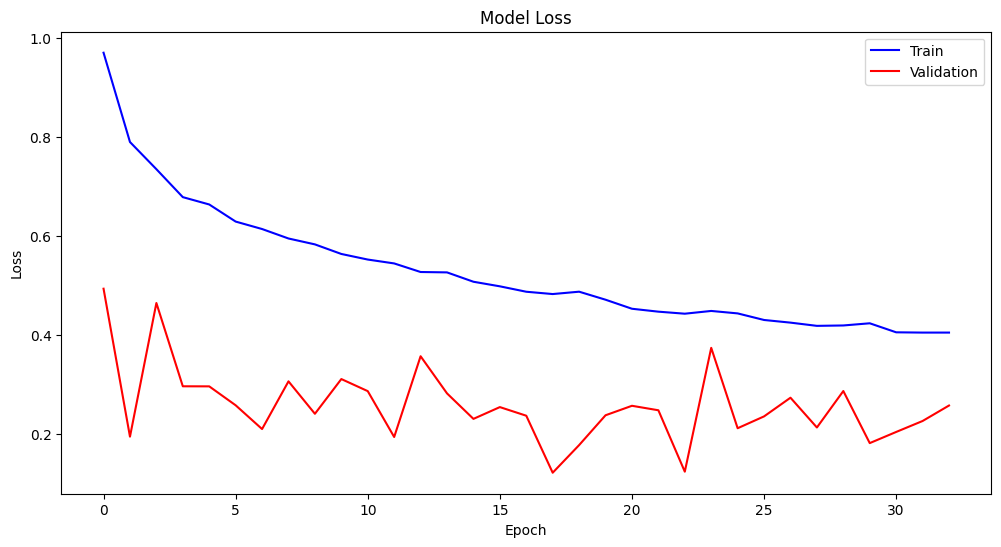

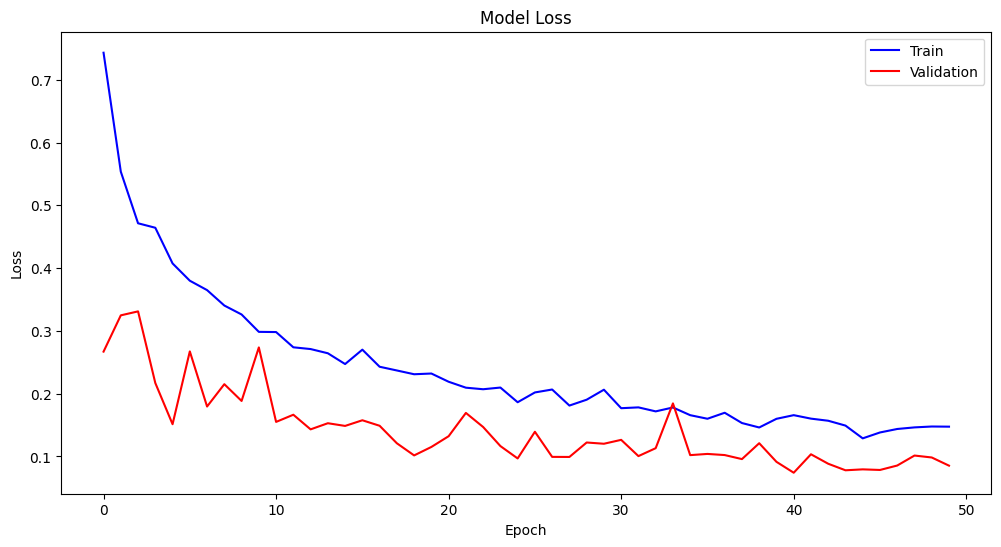

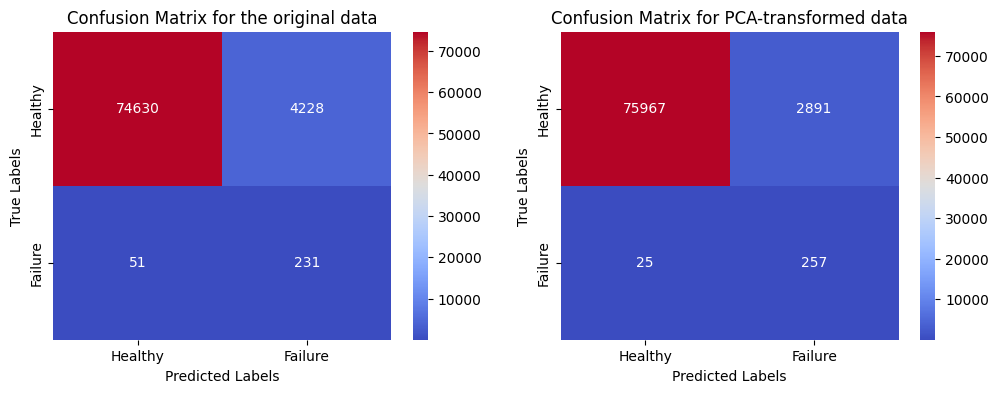

In [21]:

cm = project.Dense_Neural_Network(features,labels,labels_names)
cm_PCA = project.Dense_Neural_Network_for_PCA(x_train_pca, x_test_pca, y_train, y_test, labels_names)
project.CM_plotter(cm, cm_PCA, labels_names)

Fig.7: Model loss as a function of epoch for (a) all-feature dataset and (b) PCA-transformed dataset.Confusion matrices for all-feature (c) and PCA-transformed (d) dataframe for health state prediction of the copper mining crusher using Deep Neural Network

7.) Based on the performance of different models, the most accurate amonsgt all is definitely the deep neural net. It predicted the health states of the crusher efficiently with more than 90% balanced accuracy on this highly unbalanced dataset. For the purposes of this project, a model which performed relatively well and in close comparison with the DNN, but at a much faster pace was deemed for selection. As such, the Histogram GB model was picked for the grid search operation henceforth.

8.) The grid search operation is performed herein. The range of hyperparameters considered fit for this search are as follows:
a) 

In [22]:
model = HistGradientBoostingClassifier(random_state=42, class_weight='balanced')
project.GridSearch(features, labels, model)

{'estimator__l2_regularization': 0, 'estimator__learning_rate': 0.1, 'estimator__loss': 'log_loss', 'estimator__max_depth': None, 'estimator__max_iter': 100, 'estimator__min_samples_leaf': 50}


In [24]:
modeler = HistGradientBoostingClassifier(learning_rate=0.1, loss ='log_loss', max_depth=None, max_features=0.2, max_iter=100, class_weight='balanced', min_samples_leaf=50, l2_regularization=0)
cm=project.ML_modeler(features,labels,labels_names,modeler)

Accuracy on train dataset: 97.55%
              precision    recall  f1-score   support

     Healthy    0.99969   0.97517   0.98728     78858
     Failure    0.11643   0.91489   0.20657       282

    accuracy                        0.97496     79140
   macro avg    0.55806   0.94503   0.59692     79140
weighted avg    0.99654   0.97496   0.98450     79140

Balanced Accurancy: 0.94503
Unbalanced Accurancy: 0.97496
